#### Lab 2 Submission for jorgejc2 and ericji3

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import sympy
import yulewalker

FIR Coefficients
{0.01754934379515457, 0.02315431249063755, 0.028552314229625165, 0.03331634014026463, 0.03701803027148863, 0.03926002999427127, 0.03970808680477073, 0.03812032996498682, 0.03437129044705291, 0.028468539988971742, 0.020560335168906853, 0.010933308207510043, -4.081721798621698e-18, -0.011723177600623504, -0.02364619876172064, -0.035141874793005956, -0.045585948767361426, -0.054397951293508454, -0.06107982731466831, -0.06524947165805227, 0.9333333333333331, -0.06524947165805227, -0.06107982731466831, -0.054397951293508454, -0.045585948767361426, -0.035141874793005956, -0.02364619876172064, -0.011723177600623504, -4.081721798621698e-18, 0.010933308207510043, 0.020560335168906853, 0.028468539988971742, 0.03437129044705291, 0.03812032996498682, 0.03970808680477073, 0.03926002999427127, 0.03701803027148863, 0.03331634014026463, 0.028552314229625165, 0.02315431249063755, 0.01754934379515457};


IIR b Coefficients
{0.8817074369702885, -8.221571296895403, 32.82701927500731, -70.

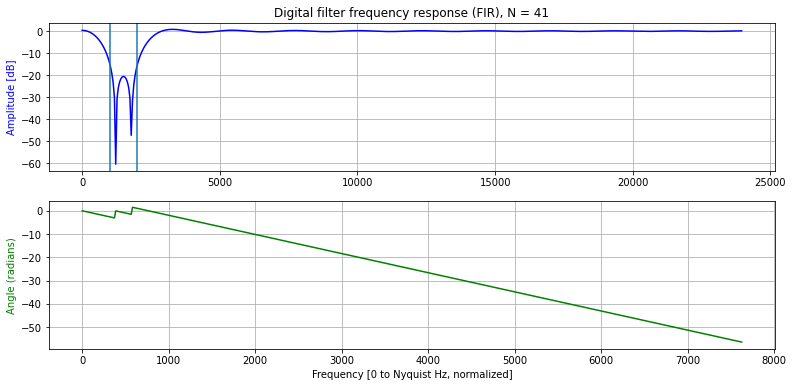

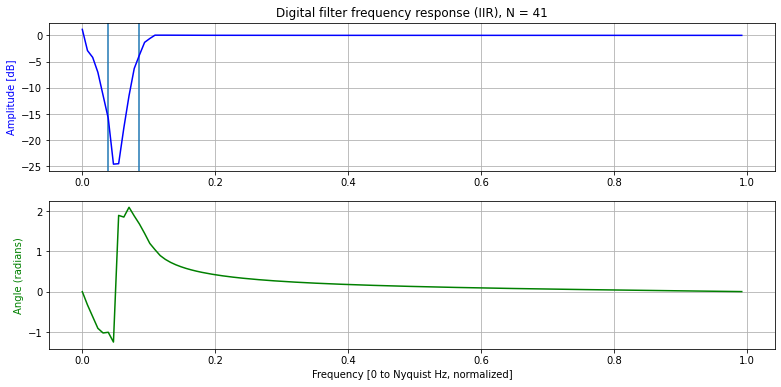

In [21]:
# Your filter design here
# firls() can be called via signal.firls()

units = 'Hz' # 'Hz'/'rad'

fs = 48000
numtaps = 41

bands = [0, 400, 400, 1000, 1000, 2000, 2000, 2600, 2600, 24000]
desired = [1,1,1,0,0,0,0,1,1,1]
f = np.array([0, 0.025, 0.03, 0.04, 0.07, 0.08, 0.095, 1])
m = np.array([1, 0.3, 0, 0, 0, 0.3, 1, 1])

a_1,b_1 = yulewalker.yulewalk(17,f,m) # generates the IIR filter
b = signal.firls(numtaps, bands, desired, weight=None, nyq=None, fs=fs) # generates the FIR filter

# coefficients of the fir filter
coef_str = "{" 
for val in b: 
    coef_str += str(val) + ", " 
coef_str = coef_str[:-2] 
coef_str += "};" 
print("FIR Coefficients")
print(coef_str)
print('\n')

# coefficients of the b iir filter
coef_str = "{" 
for val in b_1: 
    coef_str += str(val) + ", " 
coef_str = coef_str[:-2] 
coef_str += "};" 
print("IIR b Coefficients")
print(coef_str) 
print('\n')

# coefficients of the a iir filter
coef_str = "{" 
for val in a_1: 
    coef_str += str(val) + ", " 
coef_str = coef_str[:-2] 
coef_str += "};" 
print("IIR a Coefficients")
print(coef_str) 

# Signal analysis
w, h = signal.freqz(b, fs=fs) if units == 'Hz' else signal.freqz(b)
w_1, h_1 = signal.freqz(b_1, a_1, 128)

# compute magnitudes in decibals
h_mag = 20 * np.log10(abs(h))
h_1_mag = 20 * np.log10(abs(h_1))

plt.figure(figsize=(13,6))
plt.subplot(2,1,1)
plt.title('Digital filter frequency response (FIR), N = ' + str(len(b)))
plt.plot(w, h_mag, 'b') if units == 'Hz' else plt.plot(w/np.pi, h_mag, 'b')
# print frequency cut offs in Hz or radians
if units == 'Hz':
    plt.axvline(x=1000)
    plt.axvline(x=2000)
else:
    plt.axvline(x=0.13805827090970768-0.1)
    plt.axvline(x=0.25464081078901646-0.17)
plt.ylabel('Amplitude [dB]', color='b')
plt.grid()
plt.axis('tight')

plt.subplot(2,1,2)
angles = np.unwrap(np.angle(h))
plt.plot(w / np.pi, angles, 'g')
plt.ylabel('Angle (radians)', color='g')
plt.grid()
plt.axis('tight')
plt.xlabel('Frequency [0 to Nyquist Hz, normalized]')
plt.show()

plt.figure(figsize=(13,6))
plt.subplot(2,1,1)
plt.title('Digital filter frequency response (IIR), N = ' + str(len(b)))
plt.axvline(x=0.13805827090970768-0.1)
plt.axvline(x=0.25464081078901646-0.17)
plt.plot(w_1/np.pi, h_1_mag, 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.grid()
plt.axis('tight')

plt.subplot(2,1,2)
angles = np.unwrap(np.angle(h_1))
plt.plot(w_1 / np.pi, angles, 'g')
plt.ylabel('Angle (radians)', color='g')
plt.grid()
plt.axis('tight')
plt.xlabel('Frequency [0 to Nyquist Hz, normalized]')
plt.show()

#### You can design any filter if you allow the filter order to go to infinity. What are the practical considerations to using a longer filter?

**Answer**: Theoretically, taking the filter order to infinity reults in an ideal filter which better fits the design specifications. The practical considerations though is that a longer filter results in more coefficients, more memory to hold the filter, more computations, and longer delay. That is why it is better to use a shorter filter that is still close to meeting some design specifications. 

#### The sharper the transition bands, the larger the ripple in the passband. We've defined a relatively narrow stopband. How wide can you make the transition bands while still meeting your application's requirements?

**Answer**: We are using a transition band of 600 Hz. We were able to achieve a transition band of 400 Hz originally with 91 taps, but in order to decrease delay, we made the transition band greater (again 600 Hz) while simultaneously decreasing the taps to 41. The delay comes from having a longer filter as discussed from the previous question. 

Create a chirp signal and apply the filter

In [22]:
def lab_fir_filter(coef, data):
    """
    Description: Takes a FIR filter and applies it to data via a circular buffer approach
    Inputs:
            coef -- coeffiecients of the filter
            data -- data to apply filter to
    Outputs:
            None
    Returns:
            filtered_data -- array holding the values of the filtered data
    """
    num_taps = len(coef)
    filtered_data = np.zeros(len(data)) # initialize output
    circular_buffer = np.zeros(num_taps) # initialze circular buffer for holding samples
    pointer = 0 # points to the newest entry

    
    for i in range(len(data)):
        # fill buffer with a new sample
        circular_buffer[pointer] = data[i]

        # perform convolution
        sum = 0
        for j in range(num_taps):
            sum += coef[j] * circular_buffer[ (pointer - j)%num_taps]

        # hold result and update pointer
        filtered_data[i] = sum
        pointer = (pointer + 1) % len(circular_buffer)

    # return output
    return filtered_data

def lab_iir_filter(b, a, data):
        """
        Description: Takes an IIR filter and applies it to data via a circular buffer approach
        Inputs:
                b -- feedforward coeffiecients of the filter
                a -- feedback coefficients of the filter
                data -- data to apply the filter to
        Outputs:
                None
        Returns:
                y -- array holding the values of the filtered data
        """
        p = len(b) # length of feedforward filter
        q = len(a) # length of feedback filter
        y = np.zeros(len(data)) # holds previously filtered values for feedback equation

        circular_buffer = np.zeros(len(data)) # circular buffer for feedforward filter
        pointer = 0 # pointer for circ buffer

        # difference equation from https://en.wikipedia.org/wiki/Infinite_impulse_response
        for n in range(len(data)):
                sum = 0
                output_p = 0
                output_q = 0
                circular_buffer[pointer] = data[n]
                for i in range(p):
                        output_p += b[i] * circular_buffer[(n - i)% len(data)]

                for j in range(1, q):
                        output_q += a[j] * y[n - j]

                sum = (1/a[0]) * (output_p - output_q)
                y[n] = sum
                pointer = (pointer + 1) % len(data)

        return y




Does our FIR implementation match lfilter? True


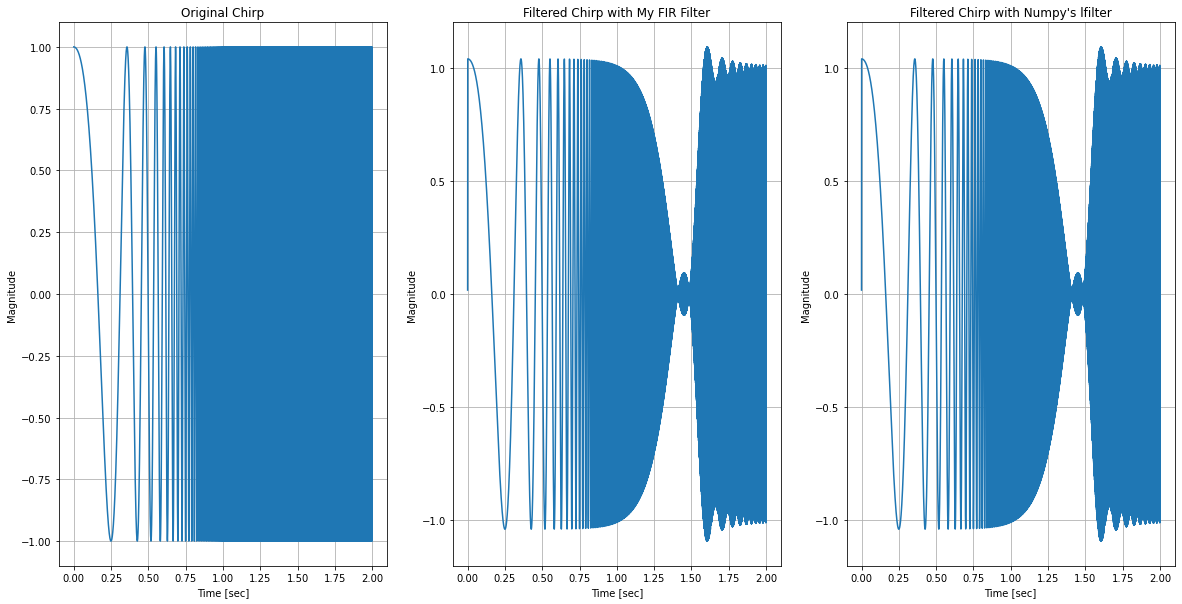

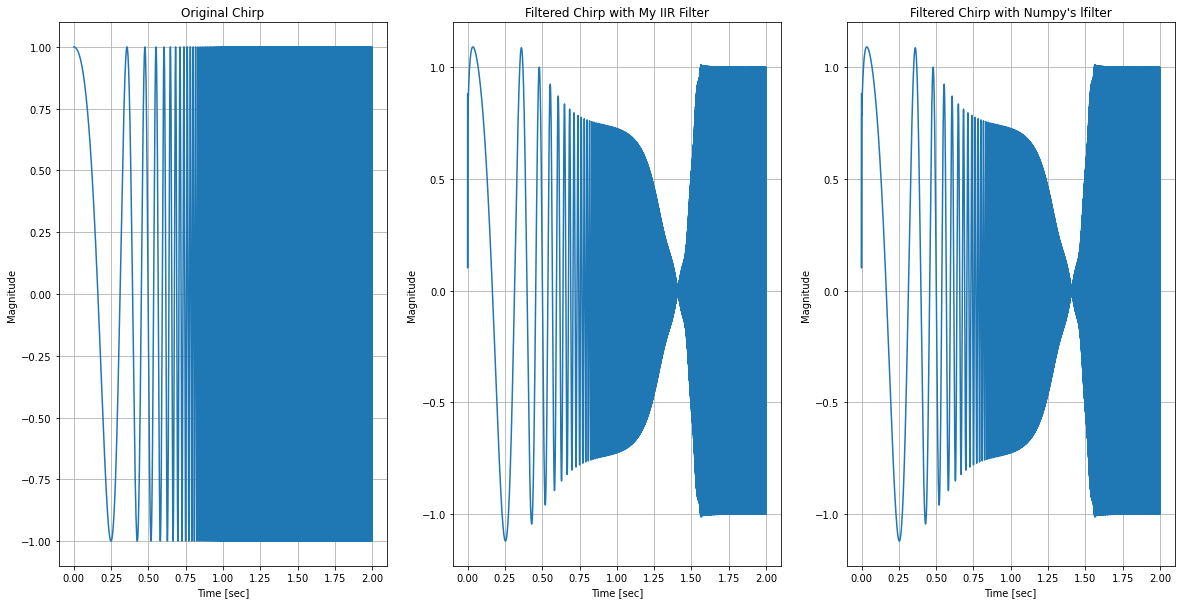

In [23]:

F_s = 48000
t = [i / F_s for i in range(2 * F_s)]

# apply FIR filter
test_data = signal.chirp(t, 1, t[-1], 24000, method='logarithmic')
filtered_test_data = lab_fir_filter(b, test_data)
lfiltered_test_data = signal.lfilter(b, [1.0], test_data)

print("Does our FIR implementation match lfilter? {}".format(np.allclose(lfiltered_test_data, filtered_test_data)))

test_data_freq = np.fft.rfft(test_data)
filtered_test_data_freq = np.fft.rfft(filtered_test_data)
lfiltered_test_data_freq = np.fft.rfft(lfiltered_test_data)
freq = np.linspace(0, fs/2, len(test_data_freq))

# do plots for FIR filter application
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title("Original Chirp")
plt.xlabel("Time [sec]")
plt.ylabel("Magnitude")
plt.grid(True)
# plt.plot(freq, test_data_freq) # pltos in frequency domain
plt.plot(t, test_data) # plots in time domain

plt.subplot(132)
plt.title("Filtered Chirp with My FIR Filter")
plt.xlabel("Time [sec]")
plt.ylabel("Magnitude")
plt.grid(True)
# plt.plot(freq, filtered_test_data_freq) # plots in frequency domain
plt.plot(t, filtered_test_data) # plots in time domain

plt.subplot(133)
plt.title("Filtered Chirp with Numpy's lfilter")
plt.xlabel("Time [sec]")
plt.ylabel("Magnitude")
plt.grid(True)
plt.plot(t, lfiltered_test_data)

# apply IIR filter
lfiltered_test_data = signal.lfilter(b_1, a_1, test_data)
filtered_test_data = lab_iir_filter(b_1, a_1, test_data)
filtered_test_data_freq = np.fft.rfft(filtered_test_data)
lfiltered_test_data_freq = np.fft.rfft(lfiltered_test_data)

freq = np.linspace(0, fs/2, len(test_data_freq))

# do plots for IIR filter application
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title("Original Chirp")
plt.xlabel("Time [sec]")
plt.ylabel("Magnitude")
plt.grid(True)
# plt.plot(freq, test_data_freq) # plots in frequency domain
plt.plot(t, test_data) # plots in time domain

plt.subplot(132)
plt.title("Filtered Chirp with My IIR Filter")
plt.xlabel("Time [sec]")
plt.ylabel("Magnitude")
plt.grid(True)
# plt.plot(freq, filtered_test_data_freq) # plots in frequency domain
plt.plot(t, filtered_test_data) # plots in time domain

plt.subplot(133)
plt.title("Filtered Chirp with Numpy's lfilter")
plt.xlabel("Time [sec]")
plt.ylabel("Magnitude")
plt.grid(True)
plt.plot(t, lfiltered_test_data)